# Final Team Project
- Hanmaro Song
- Eva Chow
- Jose Luis Estrada

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix

random_state = 123

import warnings

warnings.filterwarnings('ignore')

### Exploratory Data Analysis

| Features | Description |
| --- | --- |
| year | Year |
| month | Month |
| day | Day |
| dep_time | Departure time, in Eastern time zone |
| dep_delay | Departure delay, in minutes |
| arr_time | Arrival time, in the local time zone|
| arr_delay | Arrival delay, in minutes |
| carrier | Carrier, abbreviated |
| tailnum | Tail number of the airplane |
| flight | Flight number |
| origin | Flight origin, airport code |
| dest | Flight destination, airport code |
| air_time | Time in the air, in minutes |
| distance | Distance between the departure and arrival airports, in miles |
| hour | Scheduled departure hour |
| minute | Scheduled departure minute |

In [37]:
data = pd.read_csv('nyc-flights.csv')

data.shape

(32735, 16)

In [38]:
data.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,2013,6,30,940,15,1216,-4,VX,N626VA,407,JFK,LAX,313,2475,9,40
1,2013,5,7,1657,-3,2104,10,DL,N3760C,329,JFK,SJU,216,1598,16,57
2,2013,12,8,859,-1,1238,11,DL,N712TW,422,JFK,LAX,376,2475,8,59
3,2013,5,14,1841,-4,2122,-34,DL,N914DL,2391,JFK,TPA,135,1005,18,41
4,2013,7,21,1102,-3,1230,-8,9E,N823AY,3652,LGA,ORF,50,296,11,2


---

dep_time & hour & minute

How different are dep_time from hour + minute

In [49]:
data[['dep_time', 'hour', 'minute']].head(10)

,dep_time,hour,minute
0,940,9,40
1,1657,16,57
2,859,8,59
3,1841,18,41
4,1102,11,2
5,1817,18,17
6,1259,12,59
7,1920,19,20
8,725,7,25
9,1323,13,23


In [50]:
data[['dep_time', 'hour', 'minute']].tail(10)

,dep_time,hour,minute
32725,1437,14,37
32726,1558,15,58
32727,1716,17,16
32728,1923,19,23
32729,706,7,6
32730,752,7,52
32731,812,8,12
32732,1057,10,57
32733,844,8,44
32734,1813,18,13


When comparing, dep_time is the string representation of hour + minute (notice that single digit minute is concatenated by 0 in the front : 7hrs 6min -> 706). Because they these three columns are same, dropping hour and minute is fine

In [52]:
data.drop(columns=['hour', 'minute'], inplace=True)

---

year

In [53]:
data['year'].value_counts()

2013    32735
Name: year, dtype: int64

Because the data is only from 2013 and no variance, dropping it won't have an impact

In [59]:
data.drop(columns='year', inplace=True)

---

month & day

In [54]:
month_count = data['month'].value_counts().sort_index()
day_count = data['day'].value_counts().sort_index()

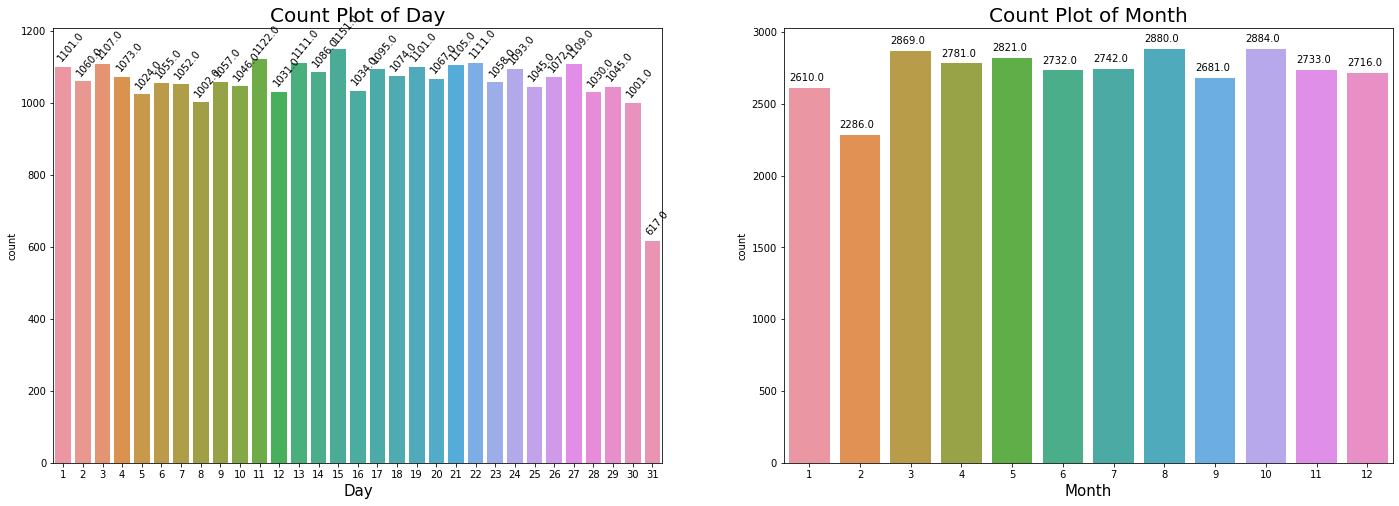

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax1 = sns.countplot(x="day", data=data, ax=ax[0])

for p in ax1.patches:
    ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+15), rotation=50)
ax1.set_xlabel('Day', size=15)
ax1.set_title('Count Plot of Day', size=20)
    
ax2 = sns.countplot(x="month", data=data, ax=ax[1])

for p in ax2.patches:
    ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+50))
ax2.set_xlabel('Month', size=15)
ax2.set_title('Count Plot of Month', size=20)

plt.show();

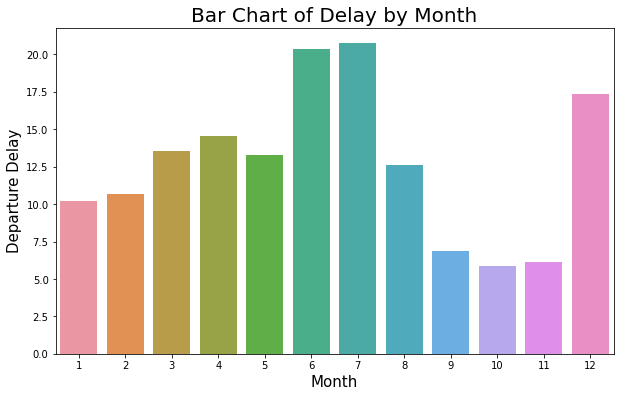

In [176]:
delay_month = data.groupby(['month'])[['dep_delay']].mean().sort_values('dep_delay', ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(x='month', y='dep_delay', data=delay_month, ax=ax)

ax.set_xlabel('Month', size=15)
ax.set_ylabel('Departure Delay', size=15)
ax.set_title('Bar Chart of Delay by Month', size=20)
plt.show();

Larger range in departure delay with skew towards longer departure delays in June, July, and December. Steady increase in departure delays leading up until July, with a drop off until December. Are departure delays correlated with holidays/peak travel periods? Holiday seasons, spring break, and summer months have longer departure delays versus the fall months.

Any specific day(s) of month have more data than other days?

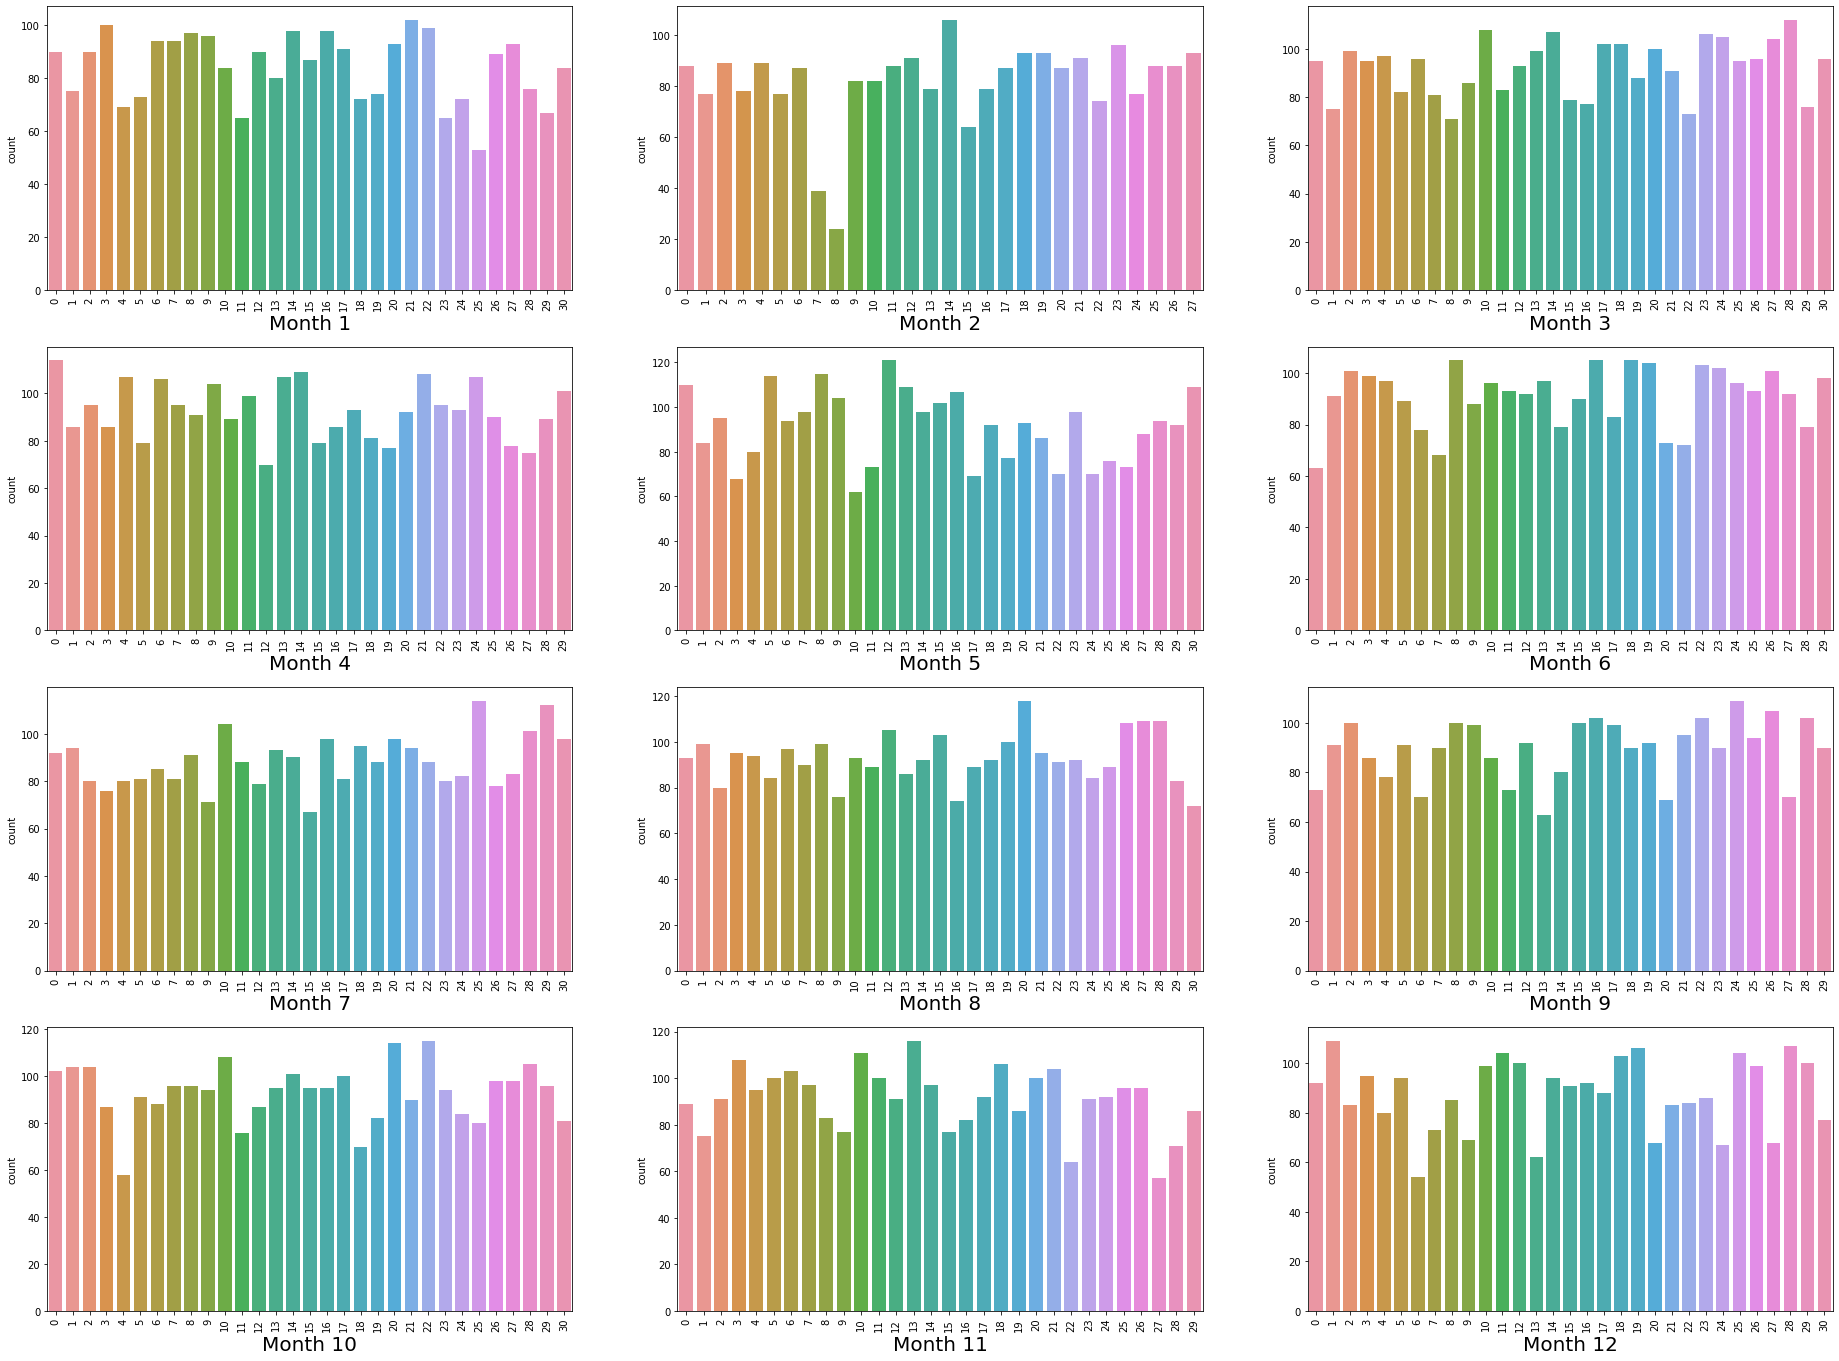

In [56]:
fig, ax = plt.subplots(4, 3, figsize=(8*4, 24))

for i in range(12):
    
    row, col = i//3, i%3

    plot = sns.countplot(x="day", data=data[data['month']==i+1], ax=ax[row][col])
    plot.set_xticklabels(plot.get_xticks(), rotation=90)
    plot.set_xlabel('Month {}'.format(i+1), size=20)

There seems to be no clear distinct patterns of days and months and they show quite similar distributions.

In [57]:
data[['day', 'month']].corr()

,day,month
day,1.000000,0.010448
month,0.010448,1.000000


And the correlation is also close to 0 and hence, it may be good to keep these two features.

In [21]:
dayspermonth = data.groupby(['day', 'month'])['dep_delay'].mean().unstack()
dayspermonth.style.highlight_max(color = 'lightgreen', axis = 0)

month,1,2,3,4,5,6,7,8,9,10,11,12
day,,,,,,,,,,,,
1,8.377778,9.488636,14.810526,14.903509,1.654545,3.079365,57.434783,30.537634,1.863014,-0.754902,12.505618,8.608696
2,8.653333,5.207792,10.280000,10.069767,5.940476,31.461538,19.882979,16.828283,57.395604,1.221154,2.320000,8.963303
3,13.366667,5.752809,6.080808,4.305263,16.842105,22.821782,24.500000,10.775000,3.850000,3.750000,6.175824,6.216867
4,9.240000,11.576923,8.705263,6.883721,13.264706,5.828283,9.144737,9.884211,1.627907,6.126437,5.138889,4.315789
5,8.144928,1.483146,6.206186,4.728972,1.725000,0.484536,4.275000,10.393617,1.641026,4.189655,1.957895,51.712500
6,6.808219,3.883117,20.804878,1.974684,6.166667,1.988764,3.135802,11.178571,-1.065934,5.868132,1.140000,12.680851
7,3.595745,3.988506,16.218750,1.877358,3.808511,28.512821,30.282353,7.721649,0.542857,46.011364,16.048544,10.259259
8,3.553191,16.743590,87.888889,3.294737,38.683673,12.720588,39.271605,33.055556,3.366667,0.250000,5.463918,18.904110
9,12.237113,22.500000,8.816901,11.021978,19.921739,11.457143,29.945055,26.535354,-1.040000,4.770833,2.325301,34.564706


Longest departure delays around major holidays?
- Feb: before Valentine's day
- Apr: spring break
- May: Memorial Day
- Sep: Labor Day
- Nov: Thanksgiving 
- Dec: Peak delay occurs around Dec 5th, but note increase in average flight delay in the week leading up to Christmas

---

origin & destination & tailnum & air time

In [61]:
data['tailnum'].value_counts()

N725MQ    59
N713MQ    53
N711MQ    48
N723MQ    47
N722MQ    46
          ..
N359AA     1
N5FBAA     1
N8631E     1
N278AT     1
N924WN     1
Name: tailnum, Length: 3490, dtype: int64

In [62]:
data['origin'].value_counts()

EWR    11771
JFK    10897
LGA    10067
Name: origin, dtype: int64

We can see there are only 3 origin airports and they are quite evenly distributed

In [63]:
data['dest'].value_counts()

ATL    1653
ORD    1588
LAX    1583
BOS    1470
CLT    1383
       ... 
JAC       2
PSP       2
CHO       1
EYW       1
ANC       1
Name: dest, Length: 102, dtype: int64

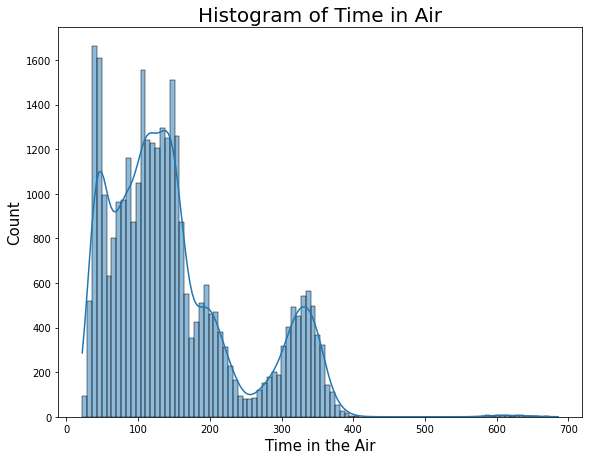

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.tight_layout()

sns.histplot(x='air_time', data=data, ax=ax, kde=True)

ax.set_title('Histogram of Time in Air', size=20)
ax.set_xlabel('Time in the Air', size=15)
ax.set_ylabel('Count', size=15)

plt.show();

If departure is delayed, this will lead to a delay in arrival in most cases. Examination below

In [102]:
delay_data = data[['tailnum', 'dep_delay', 'arr_delay']].groupby('tailnum').mean().sort_values('dep_delay', ascending=False).reset_index()

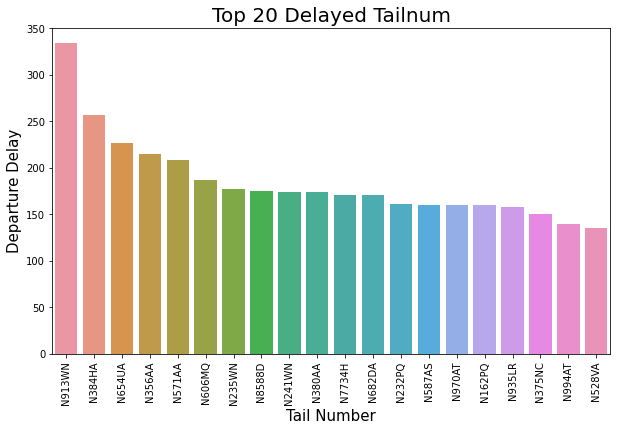

In [105]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(x='tailnum', y='dep_delay', data=delay_data.iloc[:20], ax=ax)

ax.set_xticklabels(delay_data.iloc[:20]['tailnum'], rotation=90)
ax.set_xlabel('Tail Number', size=15)
ax.set_ylabel('Departure Delay', size=15)
ax.set_title('Top 20 Delayed Tailnum', size=20)
plt.show();

Seems that tailnum **N913WN** causes the most delay. 

In [109]:
delay_data.drop(columns='tailnum').corr()

,dep_delay,arr_delay
dep_delay,1.000000,0.913046
arr_delay,0.913046,1.000000


There is actually highly correlated relationship between these two delays as mentioned above.

Also we are mainly focusing on departure delay, we can drop arrival delay feature

In [110]:
data.drop(columns='arr_delay', inplace=True)

Because there are 3490 unique tailnum values, is it good to keep them as categorical feature or drop it? It's possible that some tailnum values have higher than others because they happen more.

In [149]:
tailnum_count = data[['dep_delay', 'tailnum']].groupby('tailnum').count().sort_index().rename(columns={'dep_delay':'count_delay'})
tailnum_count['avg_delay'] = data[['dep_delay', 'tailnum']].groupby('tailnum').mean().sort_index()['dep_delay']
tailnum_count.sort_values('avg_delay', ascending=False).head()

KeyError: "['tailnum'] not in index"

In [131]:
tailnum_count.corr()

,count_delay,avg_delay
count_delay,1.000000,0.012759
avg_delay,0.012759,1.000000


Based on the counts and average delays as well as the correlation between these two, tailnum doesn't seem to impact much on the delay. This also makes some sense because for example with N913WN, the delay happened only once with 334.0 value with highest delay. But this could just be due to air traffic of other planes and/or surrounding environment. With this reasnoning, try modeling without this tailnum feature

In [137]:
data.drop(columns='tailnum', inplace=True)

---

Carrier & Departure Delay

Apply similar approach with carrier that's done to tailnum above

In [148]:
carrier_count = data[['dep_delay', 'carrier']].groupby('carrier').count().sort_index().rename(columns={'dep_delay':'count_delay'})
carrier_count['avg_delay'] = data[['dep_delay', 'carrier']].groupby('carrier').mean().sort_index()['dep_delay']
carrier_count.sort_values('avg_delay', ascending=False)

,count_delay,avg_delay
carrier,,
HA,34,38.529412
OO,3,22.000000
EV,5142,20.066122
FL,307,18.368078
YV,53,18.264151
WN,1261,17.381443
9E,1696,17.285967
B6,5376,13.137091
F9,69,12.811594


Unlike tailnum, there are fixed number of carrier and not a lot, their counts are quite high and their average delay can be used. But is there correlation?

In [151]:
carrier_count.corr()

,count_delay,avg_delay
count_delay,1.000000,-0.282994
avg_delay,-0.282994,1.000000


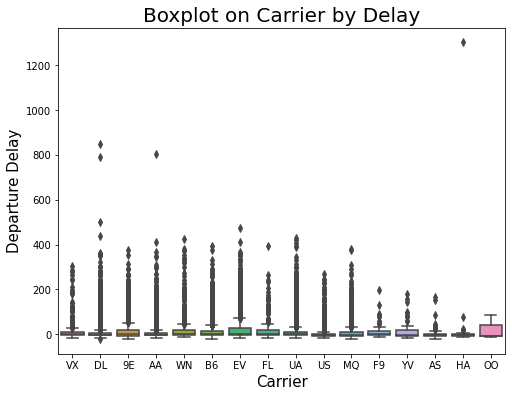

In [156]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='carrier', y='dep_delay', data=data)

plt.xlabel('Carrier', size=15)
plt.ylabel('Departure Delay', size=15)
plt.title('Boxplot on Carrier by Delay', size=20)

plt.show();

They have negative correlation but the numbers are not big enough to drop carrier predictor. Also it's actually possible carrier affects the delay as some may have more planes at NYC airport to cause traffic congestion so it could be a good idea to keep this feature.

Several outliers seen. Majority of delays don't exceed 400 minutes. A handful of airlines have delays less than 400 minutes

---

---

---

### Data exploration in relation to departure delay

#### Departure Time

In [22]:
data['dep_time'].value_counts()

755    101
655     90
556     87
557     84
656     79
      ... 
152      1
103      1
119      1
117      1
232      1
Name: dep_time, Length: 1212, dtype: int64

Text(0, 0.5, 'Departure Delay in Minutes')

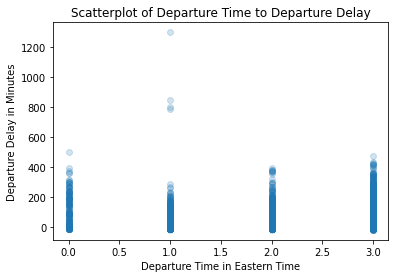

In [23]:
# scatterplot of departure time and departure delays
# departure time noted in military time

plt.scatter(data['dep_time'], data['dep_delay'], alpha = 0.2)
plt.title('Scatterplot of Departure Time to Departure Delay')
plt.xlabel('Departure Time in Eastern Time')
plt.ylabel('Departure Delay in Minutes')

Steady increase in departure delay time as the day progresses from around 5AM to midnight. This is followed by a sharp decline in departure delay.

---

#### Origin

<AxesSubplot:title={'center':'dep_delay'}, xlabel='origin'>

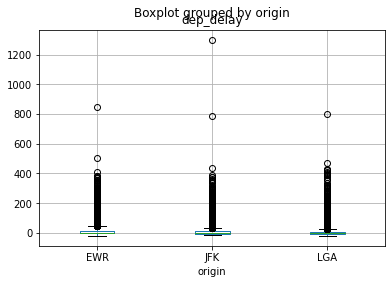

In [24]:
data.boxplot(by='origin', column='dep_delay')

<AxesSubplot:title={'center':'dep_delay'}, xlabel='origin'>

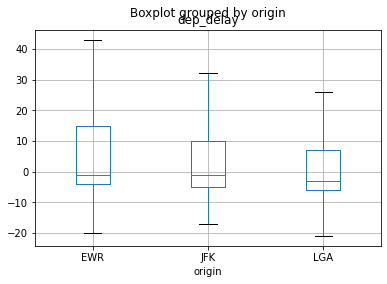

In [25]:
# remove outliers

data.boxplot(by='origin', column='dep_delay', showfliers = False)

After removing outliers, EWR airport seems to experience longer departure delays, followed by JFK, then LGA.

---

#### Destination

In [26]:
data['dest'].value_counts()

ATL    1653
ORD    1588
LAX    1583
BOS    1470
CLT    1383
       ... 
JAC       2
PSP       2
CHO       1
EYW       1
ANC       1
Name: dest, Length: 102, dtype: int64

Potentially drop dest? 102 unique destinations with uneven distribution of data across destination locations.

---

#### Hour

In [36]:
plt.scatter(data['hour'], data['dep_delay'], alpha = 0.2)
plt.title('Scatterplot of Scheduled Departure Hour to Departure Delay')
plt.xlabel('Scheduled Departure Hour in Military Time')
plt.ylabel('Departure Delay in Minutes')

KeyError: 'hour'

Distribution is similar to dep_time. We could keep both variables or drop one. Need to check for potential multicollinearity

In [28]:
# multicollinearity check

multi = data[['dep_delay', 'dep_time', 'hour']]

multi_df = pd.DataFrame()
multi_df['Variable'] = multi.columns

multi_df['VIF'] = [variance_inflation_factor(multi.values, i)
                  for i in range(len(multi.columns))]

multi_df

,Variable,VIF
0,dep_delay,1.170344
1,dep_time,4269.152732
2,hour,4274.954941


'dep_time' and 'hour' have very high variance inflation factor values, so will drop 'hour' and keep 'dep_time' as the departure time variable

---

### Predictors and Target Variable

Suggested Variables to Drop:
- 'year': all data is from 2013, making this irrelevant (unless we combine with month + day to create datetime)
- 'arr_time': might not be useful for our objective? not sure
- 'arr_delay': also not sure. could be useful for potential marketing opportunities of services for delayed flyers, but I suspect most flyers want to be out of the airport at this point and there is little to gain from marketing for services upon arrival
- 'tailnum': unique plane identifier; this shouldn't have any impact on delays
- 'flight': unique flight identifier; this shoudln't have any impact on delays
- 'dest': a lot of unique values with uneven representation
- 'hour': displays increase in delay time as the hours pass, but pattern is similar to dep_time and shows high multicollinearity. will only keep dep_time


Suggested Predictor Variables:
- 'carrier': noted variation in departure delay across carriers
- 'month': noted variation in departure delay according to month (possibly linked to holidays and may need to convert to categorical)
- 'day': certain days are noted to show significant increase in departure delay time (as it relates to month, might need to combine with month into single variable for all encompassing datetime variable)
- 'dep_time': scatterplot shows increase in delay time as the day progresses
- 'origin': noted extended departure delay depending on which New York airport a flyer is traveling from
- 'hour': displays increase in delay time as the hours pass, but pattern is similar to dep_time

Suggested Target Variable:
- 'dep_delay': if we want to focus our business brief on suggesting marketing strategies as they relate to delays, we may need to set an arbitrary departure delay time at which we distinguish between no/short delay and long delays
    - i.e. 60 minute delay is the cutoff at which some flyers may consider looking around the airport for souvenirs/food/drink and 4 hours is the cutoff at which some flyers may consider looking for restaurants independent of the airport to dine at

In [29]:
data

,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
0,6,30,940,15,1216,-4,VX,N626VA,407,JFK,LAX,313,2475,9,40
1,5,7,1657,-3,2104,10,DL,N3760C,329,JFK,SJU,216,1598,16,57
2,12,8,859,-1,1238,11,DL,N712TW,422,JFK,LAX,376,2475,8,59
3,5,14,1841,-4,2122,-34,DL,N914DL,2391,JFK,TPA,135,1005,18,41
4,7,21,1102,-3,1230,-8,9E,N823AY,3652,LGA,ORF,50,296,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32730,10,8,752,-8,921,-28,9E,N8505Q,3611,JFK,PIT,63,340,7,52
32731,7,7,812,-3,1043,8,DL,N6713Y,1429,JFK,LAS,286,2248,8,12
32732,9,3,1057,-1,1319,-19,UA,N77871,1545,EWR,IAH,180,1400,10,57
32733,10,15,844,56,1045,60,B6,N258JB,1273,JFK,CHS,93,636,8,44


In [30]:
#Transform time variable into four categorical values
departure = []
for hour in data['dep_time']:
    aux = 0
    if hour < 600:
        aux = 0
    elif hour >= 600 and hour < 1200:
        aux = 1
    elif hour >= 1200 and hour < 1600:
        aux = 2
    else:
        aux = 3
    departure.append(aux)

data['dep_time'] = departure

In [31]:
#Transform time variable into four categorical values
arrival = []
for hour in data['arr_time']:
    aux = 0
    if hour < 600:
        aux = 0
    elif hour >= 600 and hour < 1200:
        aux = 1
    elif hour >= 1200 and hour < 1800:
        aux = 2
    else:
        aux = 3
    arrival.append(aux)

data['arr_time'] = arrival


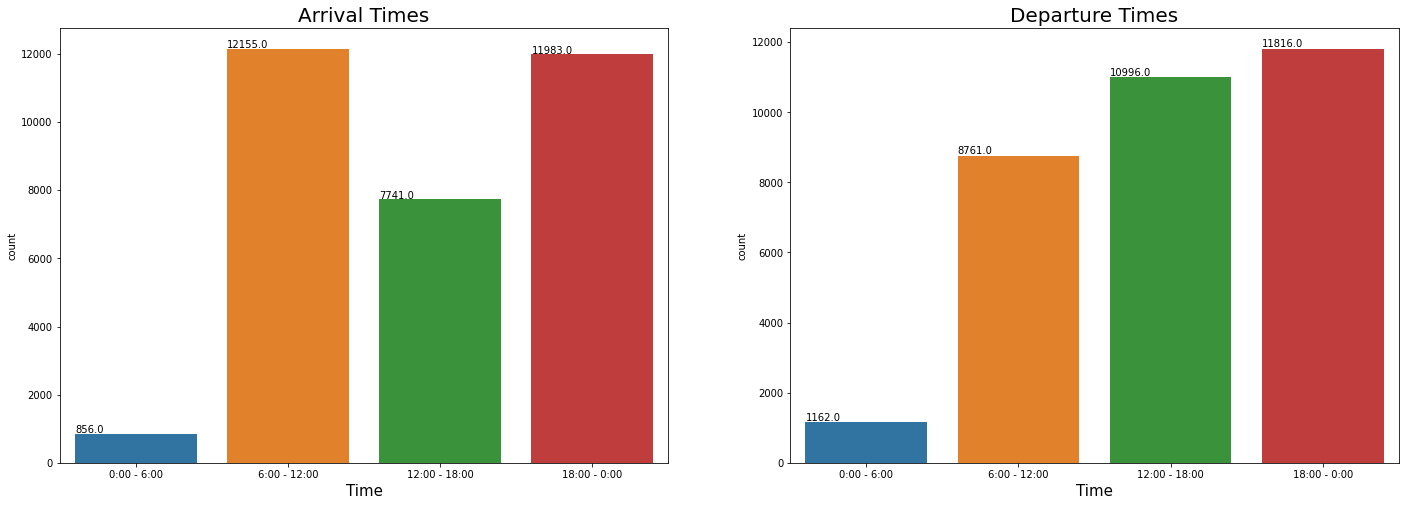

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax1 = sns.countplot(x="dep_time", data=data, ax=ax[0])

for p in ax1.patches:
    ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+15))
ax1.set_xlabel('Time', size=15)
ax1.set_title('Arrival Times', size=20)
ax1.set(xticklabels=["0:00 - 6:00", "6:00 - 12:00", "12:00 - 18:00", "18:00 - 0:00"])
    
ax2 = sns.countplot(x="arr_time", data=data, ax=ax[1])

for p in ax2.patches:
    ax2.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+50))
ax2.set_xlabel('Time', size=15)
ax2.set_title('Departure Times', size=20)
ax2.set(xticklabels=["0:00 - 6:00", "6:00 - 12:00", "12:00 - 18:00", "18:00 - 0:00"])

plt.show();

In [33]:
carrier_dummies = pd.get_dummies(data['carrier'])
origin_dummies = pd.get_dummies(data['origin'])
dest_dummies = pd.get_dummies(data['dest'])

#Dropped columns that were converted into dummy variables
#Dropped tailnum since there many instances that not repeated more than once
#Dropped hour and time since it is a copy from dep_time
data = data.drop(columns = ['carrier', 'origin', 'dest', 'tailnum','hour', 'minute'])

data = pd.concat([data, carrier_dummies, origin_dummies, dest_dummies], axis = 1)

In [34]:
data.head(25)

,month,day,dep_time,dep_delay,arr_time,arr_delay,flight,air_time,distance,9E,...,SNA,SRQ,STL,STT,SYR,TPA,TUL,TVC,TYS,XNA
0,6,30,1,15,2,-4,407,313,2475,0,...,0,0,0,0,0,0,0,0,0,0
1,5,7,3,-3,3,10,329,216,1598,0,...,0,0,0,0,0,0,0,0,0,0
2,12,8,1,-1,2,11,422,376,2475,0,...,0,0,0,0,0,0,0,0,0,0
3,5,14,3,-4,3,-34,2391,135,1005,0,...,0,0,0,0,0,1,0,0,0,0
4,7,21,1,-3,2,-8,3652,50,296,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,3,-3,3,3,353,138,733,0,...,0,0,0,0,0,0,0,0,0,0
6,12,9,2,14,2,22,1428,240,1411,0,...,0,0,0,0,0,0,0,0,0,0
7,8,13,3,85,3,71,1407,48,228,0,...,0,0,0,0,0,0,0,0,0,0
8,9,26,1,-10,1,-8,2279,148,1096,0,...,0,0,0,0,0,0,0,0,0,0
9,4,30,2,62,2,60,4162,110,820,0,...,0,0,0,0,0,0,0,0,0,0


---

### Summary of changes:

- Transformed arr_time and dep_time to categorical variable (24hrs/6hrs categories), and eliminated hour and minute variables (same information than dep_time)

- Created dummy variables for carrier, origin, and destination. Dropped variables after converting them into dummy variables

- Dropped tailgate since there are too many results that are equal to 1


### To - do:

- Select or transform target variable (departure or arrival time), would this be a continuous number prediction or a binary?

- Split dataset into valid, train, and test sets. Train models and measure metrics to select best model.